In [1]:
import salem
import cleo
import pandas as pd
import geopandas as gpd
import xarray as xr
import shapely.geometry as shpg
import matplotlib.pyplot as plt  
import numpy as np 
import cartopy 
import cartopy.crs as ccrs
from glob import glob
%matplotlib inline
# The commands below are not important
import warnings
warnings.filterwarnings('ignore')

## Prepare the files 

In [2]:
ddir = '/home/mowglie/disk/Dropbox/Share/Lehre/MA_Siller/data_vorstudie/'
shapefile = ddir + 'riosan_sel.shp'
ncfile = ddir + 'gpm_d_rio_santa.nc'
erafile = ddir + 'data_pl_200_U.nc'

In [3]:
ds = xr.open_dataset(ncfile)

In [4]:
ds

<xarray.Dataset>
Dimensions:           (lat: 23, lon: 18, time: 672)
Coordinates:
  * lat               (lat) float32 -10.55 -10.45 -10.35 -10.25 -10.15 ...
  * lon               (lon) float32 -78.35 -78.25 -78.15 -78.05 -77.95 ...
  * time              (time) datetime64[ns] 2014-03-31 2014-04-01 2014-04-02 ...
Data variables:
    precipitationCal  (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    precipitationHQ   (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.31 0.0 ...

## Quick analysis

In [5]:
dsm = ds.mean(dim='time')

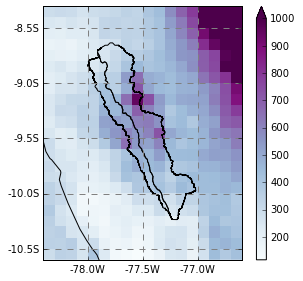

In [6]:
cm = cleo.Map(ds.salem.grid)
cm.set_data((dsm.precipitationCal * 365).values)  # quick and dirty way to get "annual" values
cm.set_plot_params(nlevels=256, vmax=1000)
cm.set_cmap(plt.get_cmap('BuPu'))
cm.set_shapefile(shapefile)
cm.visualize()

In [7]:
# Make a region of interest for the rio santa
ds.salem.set_roi(shape=shapefile)
ds_roi = ds.where(ds.salem.roi)

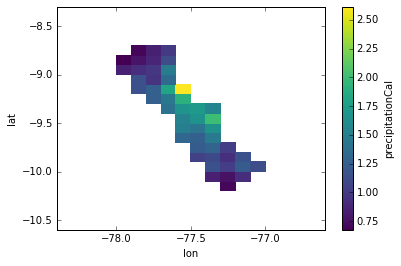

In [8]:
ds_roi.mean(dim=['time']).precipitationCal.plot();

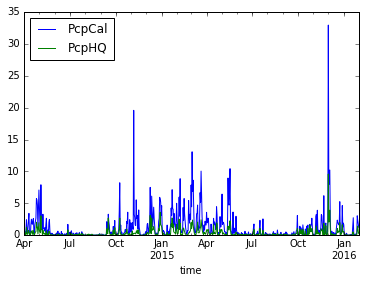

In [9]:
# Make a Pandas DataFrame becuse its easier to handle time series
df = pd.DataFrame()
df['PcpCal'] = ds_roi.mean(dim=['lon', 'lat']).precipitationCal.to_series()
df['PcpHQ'] = ds_roi.mean(dim=['lon', 'lat']).precipitationHQ.to_series()
df.plot();

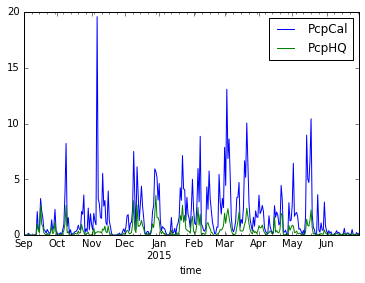

In [10]:
df.loc['2014/09/01':'2015/06/30'].plot();

## And ERA int?

In [11]:
dse = xr.open_dataset(erafile)
dse['longitude'] -= 360  # This is because era interim is from 0 to 360;

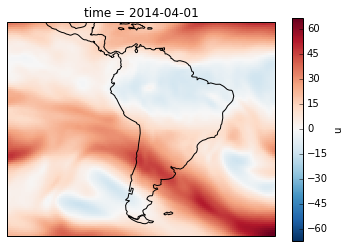

In [12]:
ax = plt.axes(projection=ccrs.PlateCarree())
dse.u.isel(time=0).plot.imshow(ax=ax, transform=ccrs.PlateCarree());
ax.coastlines();

In [13]:
# Take the Rio-Santa pixel
dse = dse.salem.subset(shape=shapefile, margin=1)
dse.salem.set_roi(shape=shapefile)
dse_roi = dse.where(dse.salem.roi)

In [14]:
# Daily average
tsu = dse_roi.mean(dim=['latitude', 'longitude']).u.to_series().resample('D').mean()

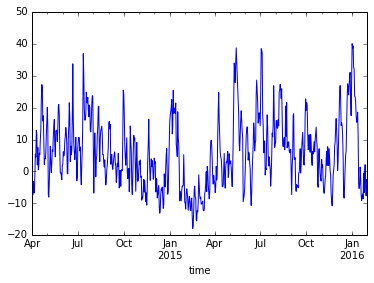

In [15]:
tsu.plot();

## PRecipitation and U together 

In [16]:
df['U_wind'] = tsu

In [17]:
dfs = df.loc['2014/10/01':'2015/03/30'].copy()

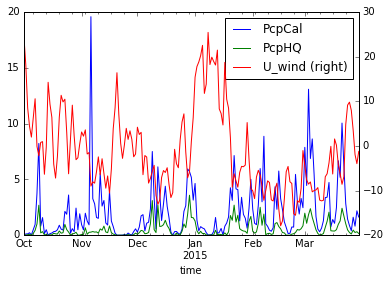

In [18]:
dfs.plot(secondary_y='U_wind');

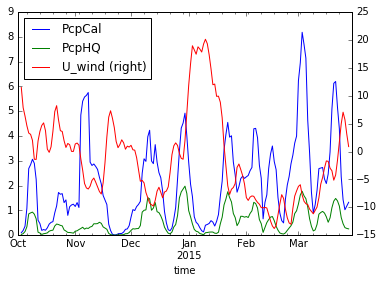

In [19]:
# Rolling average
dfs.rolling(5, center=True).mean().plot(secondary_y='U_wind');

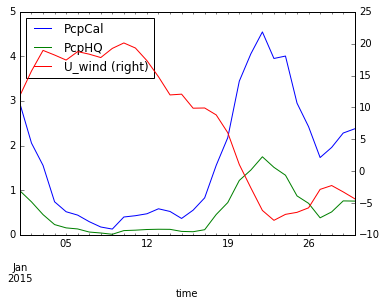

In [20]:
# zoom in January
dfs.rolling(5, center=True).mean().loc['2015/01/01':'2015/01/30'].plot(secondary_y='U_wind');

In [21]:
# correlations
dfs.rolling(5, center=True).mean().corr()

,PcpCal,PcpHQ,U_wind
PcpCal,1.000000,0.821117,-0.470178
PcpHQ,0.821117,1.000000,-0.347786
U_wind,-0.470178,-0.347786,1.000000


## And stations? 

In [22]:
dfs = pd.read_csv(ddir + 'senahmi_metadata.csv', sep=';', header=None, index_col=0).T.rename(columns=lambda x: x.strip())
dfs['LAT'] = dfs['LAT'].values.astype(np.float)
dfs['LON'] = dfs['LON'].values.astype(np.float)
dfs['HEIGHT'] = dfs['HEIGHT'].values.astype(np.float)
dfs

,LAT,LON,HEIGHT,NAME
1,-9.7817,-77.6069,3360.0,AIJA
2,-9.6329,-77.7411,3028.0,CAJAMARQUILL
3,-9.5355,-77.7756,2285.0,CHACCHAN
4,-10.2074,-77.5587,1284.0,CHAMANA
5,-9.5860,-77.1753,3151.0,CHAVIN
6,-9.5860,-77.1753,3151.0,CHAVIN_SUT
7,-10.1500,-77.1500,3350.0,CHIQUIAN
8,-9.9333,-77.6500,3500.0,MALVAS
9,-10.1578,-77.4322,3351.0,MAYORARCA
10,-9.8833,-77.2333,4400.0,MILPO_1


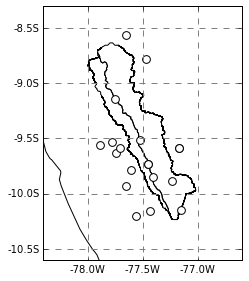

In [23]:
cm = cleo.Map(ds.salem.grid)
for lon, lat in zip(dfs['LON'], dfs['LAT']):
    cm.set_geometry(shpg.Point(lon, lat))
cm.set_shapefile(shapefile)
cm.visualize()

In [24]:
dfs = pd.read_csv(ddir + 'senahmi_data.csv', sep=';', index_col=0, parse_dates=True).rename(columns=lambda x: x.strip())
for n in dfs.columns:
    dfs[n] = dfs[n].values.astype(np.float)
dfs

,AIJA,CAJAMARQUILL,CHACCHAN,CHAMANA,CHAVIN,CHAVIN_SUT,CHIQUIAN,MALVAS,MAYORARCA,MILPO_1,NUEVO_PACHAC,PARIACOTO,PIRA,POMABAMBA,RECUAY,RECUAY_SUT,SANTIAGO_ANT,SIHUAS,YUNGAY
DATE,,,,,,,,,,,,,,,,,,,
2014-01-10,1.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-9999.0,0.0,0.00,0.0,0.0,-9999.0,0.0,0.0,0.0
2014-02-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-9999.0,0.0,0.00,0.0,0.0,-9999.0,0.0,0.0,0.0
2014-03-10,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,-9999.0,0.0,1.30,0.0,0.0,-9999.0,2.8,0.0,0.0
2014-04-10,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,-9999.0,0.0,0.00,0.0,0.0,-9999.0,1.3,0.0,0.0
2014-05-10,0.0,0.0,0.0,0.0,2.3,0.1,0.0,0.0,0.5,0.8,-9999.0,0.0,0.00,0.0,0.0,-9999.0,0.0,0.0,0.0
2014-06-10,3.6,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,-9999.0,0.0,0.60,0.0,0.0,-9999.0,0.6,0.0,0.0
2014-07-10,0.6,0.0,0.0,0.0,2.4,0.2,0.0,0.0,0.0,0.0,-9999.0,0.0,0.80,0.0,5.0,-9999.0,4.4,5.1,0.0
2014-08-10,3.8,0.0,0.0,0.0,15.0,-9999.0,0.0,3.2,3.1,0.0,-9999.0,0.0,6.45,27.2,10.1,-9999.0,11.5,4.1,12.5
2014-09-10,4.2,0.0,0.0,0.0,2.7,7.1,0.0,3.3,4.3,0.0,-9999.0,0.0,0.00,2.0,2.4,-9999.0,2.4,15.5,0.0


In [25]:
dfs = dfs[dfs >= 0.]

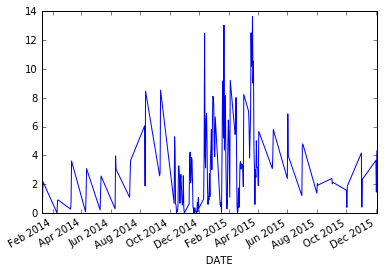

In [26]:
dfs.mean(axis=1).plot(); 

Ugh. this is ugly